Nome: Rodrigo Franciozi R. da Silva

RA: 20.83984-7

Data: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
file_path = '/content/drive/MyDrive/Education/IMT/Pós Graduação/IA com Deep Learning/Developing Neural Network Tools/Atividade 2/winequality-red.csv'

#Checking the file encoder
with open(file_path) as f:
    print(f)

<_io.TextIOWrapper name='/content/drive/MyDrive/Education/IMT/Pós Graduação/IA com Deep Learning/Developing Neural Network Tools/Atividade 2/winequality-red.csv' mode='r' encoding='UTF-8'>


In [3]:
df = pd.read_csv(file_path)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
# Data dimensions
print('Dimensões dos dados =', df.shape)

Dimensões dos dados = (1599, 12)


In [7]:
#Defining graphic colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Changing the 'quality' column

In this work, we will classify the wines as Good or Bad. Let's consider a wine bad if it's score `quality is <= 5` and good if `quality > 5` 

After creating a new column with this boolean classification, lets just remove the 'quality' column since we don't need it anymore (for this study).

In [8]:
df_wines = df.copy()

#Creating and replacing the 'quality' column with 0 or 1 (for a classification problem)
df_wines['quality_bool'] = np.where(df_wines['quality'] <= 5 , 0, np.where(df_wines['quality'] > 5, 1 , "")).astype('float64')

#Removing the Quality Data
df_wines.pop('quality')

df_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_bool
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


In [9]:
#Checking if the new class is inballanced
df_wines['quality_bool'].value_counts(normalize=True)

1.0    0.534709
0.0    0.465291
Name: quality_bool, dtype: float64

Considering we have almost 50% of 0 and 1, I don't think this will represent a problem when creating the model. 

# Splitting the Data

In [10]:
# Splitting (80% - 20%)
train_df, test_df = train_test_split(df_wines, test_size=0.2)
test_df, val_df = train_test_split(test_df, test_size=0.5)

# Spliting the outputs and transforming them in numpy tensors
train_labels = np.array(train_df.pop('quality_bool'))
val_labels = np.array(val_df.pop('quality_bool'))
test_labels = np.array(test_df.pop('quality_bool'))

# Transforming the inputs in numpy tensors
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# Normalizing

In [11]:
# Calculates the mean and standard deviation for each training data column
mean = np.mean(train_features, axis=0)
std = np.std(train_features, axis=0)

# Normalizes training data, validation and test using the mean and standard deviation from the training data
train_features = (train_features - mean)/std
val_features = (val_features - mean)/std
test_features = (test_features - mean)/std

print('Training Output Dimensions:', train_labels.shape)
print('Validation Output Dimensions:', val_labels.shape)
print('Test Output Dimensions:', test_labels.shape)
print('Training Input Dimensions:', train_features.shape)
print('Validation Input Dimensions:', val_features.shape)
print('Test Input Dimensions:', test_features.shape)

Training Output Dimensions: (1279,)
Validation Output Dimensions: (160,)
Test Output Dimensions: (160,)
Training Input Dimensions: (1279, 11)
Validation Input Dimensions: (160, 11)
Test Input Dimensions: (160, 11)


# Building the RNA

## RNA definition and Metrics

In [12]:
# Import model classes and layers fromo Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define metrics
METRICS = [
keras.metrics.TruePositives(name='tp'),
keras.metrics.FalsePositives(name='fp'),
keras.metrics.TrueNegatives(name='tn'),
keras.metrics.FalseNegatives(name='fn'),
keras.metrics.BinaryAccuracy(name='accuracy'),
keras.metrics.Precision(name='precision'),
keras.metrics.Recall(name='recall'),
keras.metrics.AUC(name='auc')]

# Function to create and compile the RNA
def make_model(METRICS, INPUT_DIM):
  
  # Network Setting
  rna = Sequential()
  rna.add(Dense(units= 32, activation= 'relu', input_dim= INPUT_DIM))
  rna.add(Dense(units= 16, activation= 'relu'))
  rna.add(Dense(units= 1, activation= 'sigmoid'))
  rna.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
  loss = keras.losses.BinaryCrossentropy(),
  metrics = METRICS)
  return rna

In [13]:
# feature numbers
features_shape = train_features.shape[1]
print('Dimensão dos dados de entrada =', features_shape)

# Compiled RNA (Create)
rna = make_model(METRICS, features_shape)
rna.summary()

Dimensão dos dados de entrada = 11
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
EPOCHS = 200
BATCH_SIZE = 240

# Training
history = rna.fit(train_features, train_labels, epochs = EPOCHS, batch_size = BATCH_SIZE, 
                  validation_data = (val_features, val_labels), verbose = 0)

# Analysing the Results

In [15]:
# Define function to create a graph from some metrics
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_'+metric], color = 'grey', label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])
      
        plt.legend()

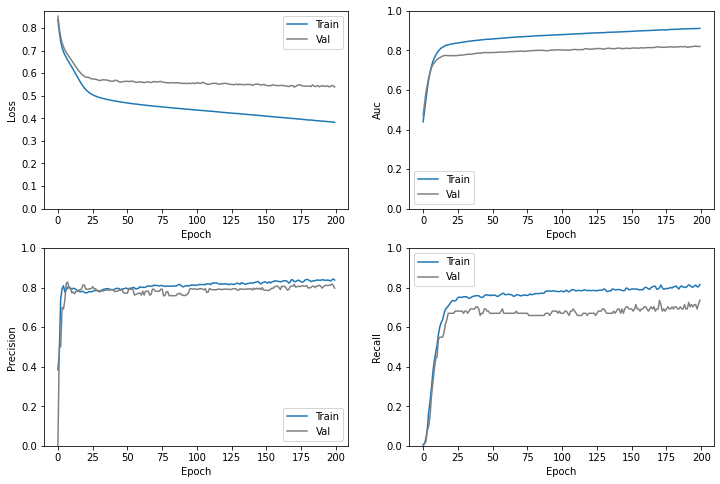

In [16]:
plot_metrics(history)

# Evaluating the Results

In [17]:
print('Number of positive examples from test set =', len(test_labels[test_labels> 0.9]))

Number of positive examples from test set = 91


In [18]:
#Test Evaluation
base_results = rna.evaluate(test_features, test_labels, batch_size = BATCH_SIZE, verbose = 0)
for name, value in zip(rna.metrics_names, base_results):
    print(name, ': ', value)
print()

loss :  0.4563659727573395
tp :  67.0
fp :  11.0
tn :  58.0
fn :  24.0
accuracy :  0.78125
precision :  0.8589743375778198
recall :  0.7362637519836426
auc :  0.8671762943267822



In [19]:
#Train Evaluation
base_results = rna.evaluate(train_features, train_labels, batch_size = BATCH_SIZE, verbose = 0)
for name, value in zip(rna.metrics_names, base_results):
    print(name, ': ', value)
print()

loss :  0.38123831152915955
tp :  552.0
fp :  106.0
tn :  500.0
fn :  121.0
accuracy :  0.8225175738334656
precision :  0.8389057517051697
recall :  0.8202080130577087
auc :  0.9122960567474365



In [20]:
#Output Test Examples
train_pred_base = rna.predict(train_features, batch_size = BATCH_SIZE)
test_pred_base = rna.predict(test_features, batch_size = BATCH_SIZE)
print('Test examples outputs:')
print(test_pred_base[:10])

Test examples outputs:
[[0.1557236 ]
 [0.6854476 ]
 [0.21633586]
 [0.41808015]
 [0.5309093 ]
 [0.9153248 ]
 [0.5450209 ]
 [0.130543  ]
 [0.06034201]
 [0.9518492 ]]


## Confusion Matrix

COnfusion Matrix
 [[58 11]
 [24 67]]


<Figure size 432x432 with 0 Axes>

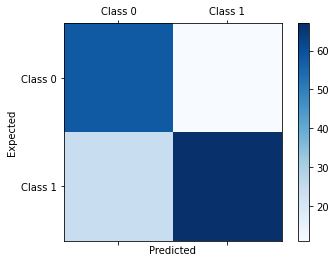

In [21]:
#Test
conf_mat = confusion_matrix(y_true= test_labels, y_pred= np.round(test_pred_base))
print('COnfusion Matrix\n', conf_mat)

labels = ['Class 0', 'Class 1']
plt.figure(figsize=(6,6))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

COnfusion Matrix
 [[500 106]
 [121 552]]


<Figure size 432x432 with 0 Axes>

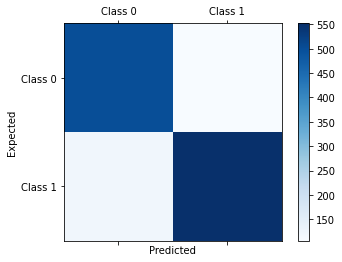

In [22]:
#Train
conf_mat = confusion_matrix(y_true= train_labels, y_pred= np.round(train_pred_base))
print('COnfusion Matrix\n', conf_mat)

labels = ['Class 0', 'Class 1']
plt.figure(figsize=(6,6))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## ROC Curve

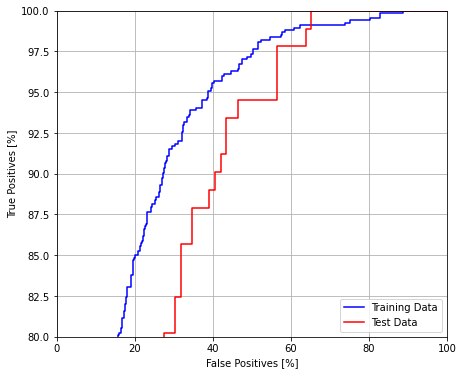

In [23]:
fp_train, tp_train, _ = sklearn.metrics.roc_curve(train_labels, train_pred_base)
fp_test, tp_test, _ = sklearn.metrics.roc_curve(test_labels, test_pred_base)
plt.figure(figsize=(7, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label= 'Training Data')
plt.plot(100*fp_test, 100*tp_test, 'r', label= 'Test Data')
plt.xlabel('False Positives [%]')
plt.ylabel('True Positives [%]')
plt.xlim([0,100])
plt.ylim([80,100])
plt.grid(True)
ax = plt.gca()
plt.legend(loc='lower right')
plt.show()

## Real and Predicted Classes

In [24]:
y_pred = rna.predict(test_features)
classes = np.round(y_pred)

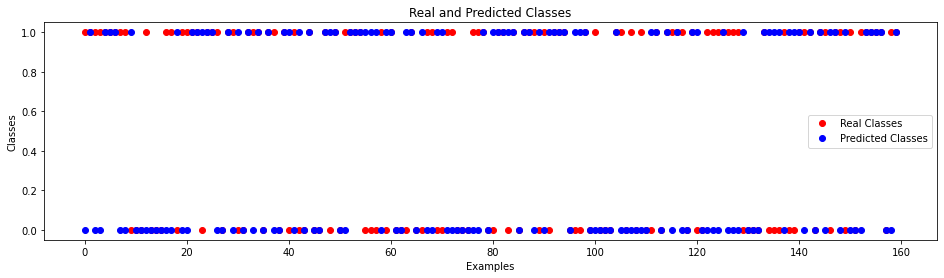

In [25]:
# Real and Predicted Classes
plt.figure(figsize=(16, 4))
plt.plot(val_labels, 'ro', label='Real Classes')
plt.plot(classes, 'bo', label='Predicted Classes')
plt.title('Real and Predicted Classes')
plt.xlabel('Examples')
plt.ylabel('Classes')
plt.legend()
plt.show()